### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import pandas as pd
import os

symbols = "NABIL"
csv_path = f"stock_history/{symbols}.csv"
df = pd.read_csv(csv_path)

# Convert 'Date' column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date in ascending order
df = df.sort_values('Date').reset_index(drop=True)
df.head()


,Date,Open,High,Low,Close,% change,Volume,TurnOver
0,2012-02-28,847.0,867.0,845.0,867.0,0.0,825.0,701623.0
1,2012-02-29,867.0,869.0,860.0,861.0,0.0,602.0,520694.0
2,2012-03-01,861.0,887.0,865.0,887.0,0.0,497.0,431750.0
3,2012-03-04,887.0,876.0,870.0,874.0,0.0,590.0,513749.0
4,2012-03-05,874.0,887.0,866.0,883.0,0.0,571.0,497711.0


In [2]:
df.tail()

,Date,Open,High,Low,Close,% change,Volume,TurnOver
2995,2025-04-03,491.0,494.0,486.1,488.73,0.72,42041.0,20602284.7
2996,2025-04-07,490.0,497.0,482.0,486.97,-0.36,46130.0,22422636.0
2997,2025-04-08,485.0,486.0,478.0,484.65,-0.48,38820.0,18746522.3
2998,2025-04-09,494.0,494.0,483.2,486.27,0.33,26187.0,12744525.0
2999,2025-04-10,491.0,492.4,484.0,485.97,-0.06,30292.0,14717797.1


In [3]:
df1=df.reset_index()['Close']

In [4]:
df1

0       867.00
1       861.00
2       887.00
3       874.00
4       883.00
         ...  
2995    488.73
2996    486.97
2997    484.65
2998    486.27
2999    485.97
Name: Close, Length: 3000, dtype: float64

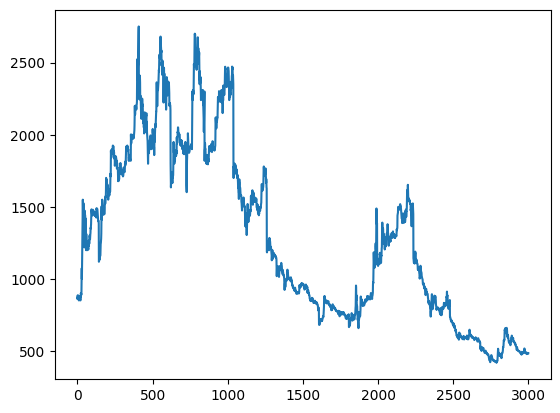

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [6]:
import numpy as np

In [7]:
df1

0       867.00
1       861.00
2       887.00
3       874.00
4       883.00
         ...  
2995    488.73
2996    486.97
2997    484.65
2998    486.27
2999    485.97
Name: Close, Length: 3000, dtype: float64

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))



In [9]:
print(df1)

[[0.1911512 ]
 [0.18857388]
 [0.19974227]
 ...
 [0.02691151]
 [0.02760739]
 [0.02747852]]


In [10]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(1950, 1050)

In [12]:
train_data

array([[0.1911512 ],
       [0.18857388],
       [0.19974227],
       ...,
       [0.18771478],
       [0.18943299],
       [0.19158076]])

In [13]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(1849, 100)
(1849,)


(None, None)

In [16]:
print(X_test.shape), print(ytest.shape)

(949, 100)
(949,)


(None, None)

In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
from tensorflow.keras.layers import Dropout

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model.compile(loss='mean_squared_error', optimizer='adam')

# Save the trained model (after training)
model.save("StockSanket.h5")



# Print the model summary (optional)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

c:\Users\Bishal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test, ytest), 
          epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/100
58/58 [==============================] - 8s 145ms/step - loss: 0.0044 - val_loss: 4.3889e-04
Epoch 2/100
58/58 [==============================] - 10s 167ms/step - loss: 0.0041 - val_loss: 6.4552e-04
Epoch 3/100
58/58 [==============================] - 7s 123ms/step - loss: 0.0039 - val_loss: 8.6955e-04
Epoch 4/100
58/58 [==============================] - 7s 122ms/step - loss: 0.0039 - val_loss: 4.3830e-04
Epoch 5/100
58/58 [==============================] - 8s 141ms/step - loss: 0.0036 - val_loss: 4.0142e-04
Epoch 6/100
58/58 [==============================] - 7s 120ms/step - loss: 0.0034 - val_loss: 4.9230e-04
Epoch 7/100
58/58 [==============================] - 8s 138ms/step - loss: 0.0033 - val_loss: 3.7860e-04
Epoch 8/100
58/58 [==============================] - 7s 125ms/step - loss: 0.0033 - val_loss: 4.5928e-04
Epoch 9/100
58/58 [==============================] - 7s 124ms/step - loss: 0.0030 - val_loss: 3.4250e-04
Epoch 10/100
58/58 [==============================] - 

In [28]:
import tensorflow as tf

In [29]:
tf.__version__

'2.13.0'

In [31]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

30/30 [==============================] - 1s 48ms/step


In [32]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [33]:
# Calculate RMSE for training and testing
from sklearn.metrics import mean_squared_error
import math

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(ytest, test_predict))


In [34]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train, train_predict)
test_mape = mean_absolute_percentage_error(ytest, test_predict)

train_accuracy = 100 - train_mape
test_accuracy = 100 - test_mape


C:\Users\Bishal\AppData\Local\Temp\ipykernel_2240\117373069.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


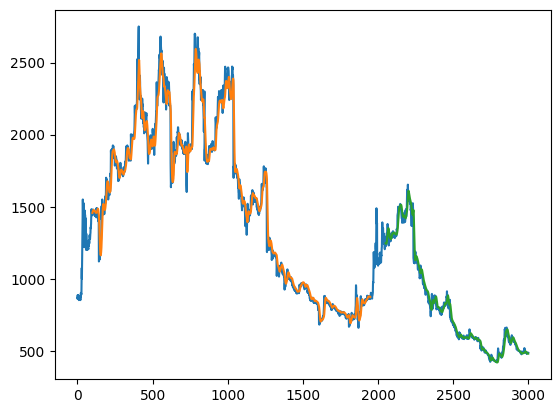

In [35]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [36]:
len(test_data)

1050

In [37]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 709)

In [38]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [39]:
temp_input

[0.2555841924398625,
 0.25214776632302405,
 0.2508591065292096,
 0.24914089347079035,
 0.2469931271477663,
 0.2469931271477663,
 0.24140893470790378,
 0.23324742268041235,
 0.23496563573883159,
 0.23582474226804126,
 0.2310996563573883,
 0.23582474226804126,
 0.23582474226804126,
 0.22938144329896906,
 0.2263745704467354,
 0.2225085910652921,
 0.22036082474226806,
 0.22744845360824742,
 0.22289518900343644,
 0.22160652920962196,
 0.22031786941580753,
 0.21735395189003434,
 0.21391752577319587,
 0.20919243986254296,
 0.20614261168384876,
 0.20060137457044672,
 0.20382302405498284,
 0.20949312714776633,
 0.21950171821305844,
 0.21821305841924396,
 0.20962199312714777,
 0.211340206185567,
 0.20876288659793815,
 0.20790378006872853,
 0.20489690721649487,
 0.20408075601374573,
 0.20532646048109968,
 0.20472508591065294,
 0.20446735395189006,
 0.20103092783505153,
 0.19458762886597938,
 0.1911512027491409,
 0.18896048109965632,
 0.18170103092783504,
 0.18213058419243985,
 0.17590206185567012

In [56]:
# 📌 Cell 1: Generate 7-day Close predictions
from numpy import array

lst_output = []
n_steps = 100
i = 0

while i < 7:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Inverse scale the predictions
forecast_prices = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).flatten()


In [62]:
# 📌 Cell 2: Generate synthetic OHLC for predicted 7 days
from datetime import timedelta
import numpy as np

last_date = pd.to_datetime(df['Date'].iloc[-1])
last_close = df['Close'].iloc[-1]

predicted_7_days = []

for close_price in forecast_prices:
    date = last_date + timedelta(days=1)
    while date.weekday() >= 5:  # skip weekends
        date += timedelta(days=1)

    open_price = last_close * (1 + np.random.uniform(-0.01, 0.01))
    high_price = max(open_price, close_price) * (1 + np.random.uniform(0.001, 0.015))
    low_price = min(open_price, close_price) * (1 - np.random.uniform(0.001, 0.015))

    predicted_7_days.append({
        "date": date.strftime('%Y-%m-%d'),
        "open": round(open_price, 2),
        "high": round(high_price, 2),
        "low": round(low_price, 2),
        "close": round(close_price, 2)
    })

    last_close = close_price
    last_date = date


In [64]:
# 📌 Cell 3: Save full JSON (past + prediction)
import os
import json

output_dir = os.path.join("predictions", symbols)
os.makedirs(output_dir, exist_ok=True)

# Convert 'Date' to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Pull past 30 OHLC days
past_30_df = df[["Date", "Open", "High", "Low", "Close"]].tail(30)
past_30_list = [
    {
        "date": row["Date"].strftime("%Y-%m-%d"),
        "open": round(row["Open"], 2),
        "high": round(row["High"], 2),
        "low": round(row["Low"], 2),
        "close": round(row["Close"], 2)
    }
    for _, row in past_30_df.iterrows()
]

output_data = {
    "past_30_days": past_30_list,
    "predicted_7_days": predicted_7_days,
    "train_rmse": train_rmse if 'train_rmse' in locals() else None,
    "test_rmse": test_rmse if 'test_rmse' in locals() else None,
    "train_accuracy": train_accuracy if 'train_accuracy' in locals() else None,
    "test_accuracy": test_accuracy if 'test_accuracy' in locals() else None
}

with open(os.path.join(output_dir, f"{symbols}.json"), "w") as f:
    json.dump(output_data, f, indent=4)


In [44]:
day_new=np.arange(1,101)
day_pred = np.arange(101, 108)  # For 7 days

In [45]:
import matplotlib.pyplot as plt

In [46]:
len(df1)

3000

In [47]:
import os

output_dir = f"predictions/{symbols}"
os.makedirs(output_dir, exist_ok=True)


In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Optional: Set figure size for better clarity

# Plot past 100 days
plt.plot(day_new, scaler.inverse_transform(np.array(df1[-100:]).reshape(-1, 1)), label="Past 100 Days")

# Plot next 7 predicted days
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)), label="Next 7 Days")

plt.title(f"{symbols} — Forecast vs History")
plt.xlabel("Days")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)

# Ensure output folder exists
os.makedirs(output_dir, exist_ok=True)

# Save plot before plt.show()
chart_path = os.path.join(output_dir, f"{symbols}_chart1.png")
plt.savefig(chart_path, bbox_inches="tight")  # Use bbox_inches to capture full content
plt.close()  # Close to free memory and prevent display issues in batch runs


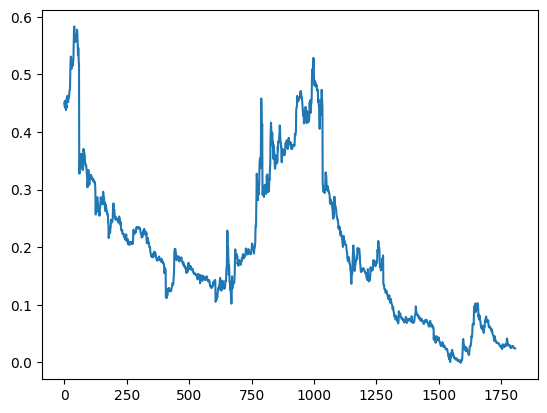

In [50]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [51]:
df3=scaler.inverse_transform(df3).tolist()

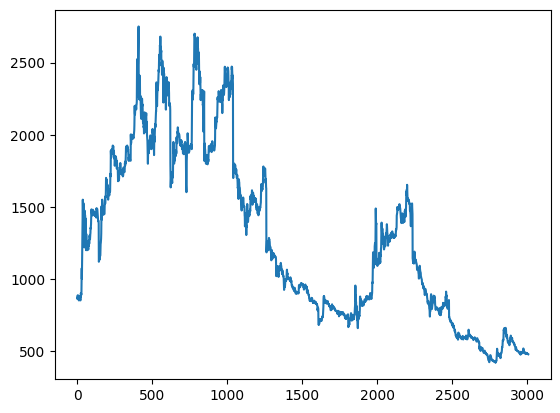

In [52]:
plt.plot(df3)


In [53]:
last_date = pd.to_datetime(df["Date"].iloc[-1])
forecast_dates = [(last_date + pd.Timedelta(days=i)).strftime("%Y-%m-%d") for i in range(1, 8)]


In [54]:

import os
output_dir = 'stock_prediction'
os.makedirs(output_dir, exist_ok=True)
